In [21]:
import sys
sys.path.append('../src')

import importlib
import dyn_accept_loop as dal
importlib.reload(dal)
import reject_inference as rinf
importlib.reload(rinf)
import helper as h
importlib.reload(h)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgbm

## Test importable Dynamic Acceptance Loop

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

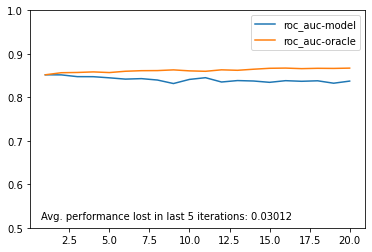

Sampling Bias: 0.03012


In [22]:
n_years = 20

model = lgbm.LGBMClassifier() # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)#rinf.EMsemisupervised)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

In [23]:
print(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years))

0.030117220239442456


## Test importable Autoencoder

In [24]:
import autoencoder as aenc
import importlib
importlib.reload(aenc)

<module 'autoencoder' from 'c:\\Projects\\Information-Systems-Seminar\\reject-infer-autoencoder\\notebooks\\../src\\autoencoder.py'>

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=25, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=25, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=68, bias=True)
  )
)


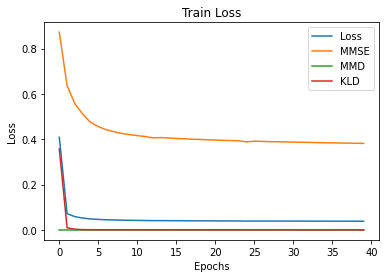

In [25]:
BATCH_SIZE = 2000
EPOCHS = 40
LR = 1e-2
LOSSFUNCWEIGHTS = [0.1, 0.9, 0.0]  #[MMSE, KLDiv, MMD]

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

shape = [dataset.x.shape[1], 45, 25, 45, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS)               

plt.figure()
plt.plot(train_loss, label='Loss')
plt.plot(train_loss_mmse, label='MMSE')
plt.plot(train_loss_mmd, label='MMD')
plt.plot(train_loss_kld, label='KLD')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 25)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 25)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 25)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 25)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 25)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 25)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 25)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 25)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 25)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 25)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 25)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 25)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

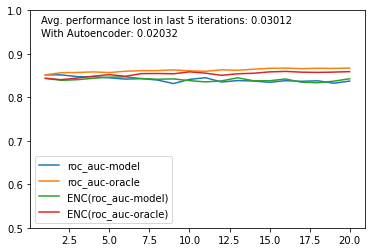

In [26]:
n_years = 20

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics2 = iteration[3]

last_n_years = 5
bias2 = h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.text(0.75, 0.97, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.text(0.75, 0.94, f'With Autoencoder: {round(bias2, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()

## Plot Parameter-Dependencies

Baseline Sampling Bias: 0.02913
Baseline ROC-AUC: 0.83706
PARAM: 10 | Sampling Bias: 0.02679 // ROC-AUC: 0.78563
PARAM: 12 | Sampling Bias: 0.02828 // ROC-AUC: 0.76857
PARAM: 14 | Sampling Bias: 0.02136 // ROC-AUC: 0.82261
PARAM: 16 | Sampling Bias: 0.02136 // ROC-AUC: 0.83598
PARAM: 18 | Sampling Bias: 0.02717 // ROC-AUC: 0.83045
PARAM: 20 | Sampling Bias: 0.02443 // ROC-AUC: 0.83703
PARAM: 22 | Sampling Bias: 0.01806 // ROC-AUC: 0.83783
PARAM: 24 | Sampling Bias: 0.01865 // ROC-AUC: 0.83857
PARAM: 26 | Sampling Bias: 0.01965 // ROC-AUC: 0.8402
PARAM: 28 | Sampling Bias: 0.01937 // ROC-AUC: 0.84194
PARAM: 30 | Sampling Bias: 0.02389 // ROC-AUC: 0.83636
PARAM: 32 | Sampling Bias: 0.01908 // ROC-AUC: 0.83963
PARAM: 34 | Sampling Bias: 0.0229 // ROC-AUC: 0.83535


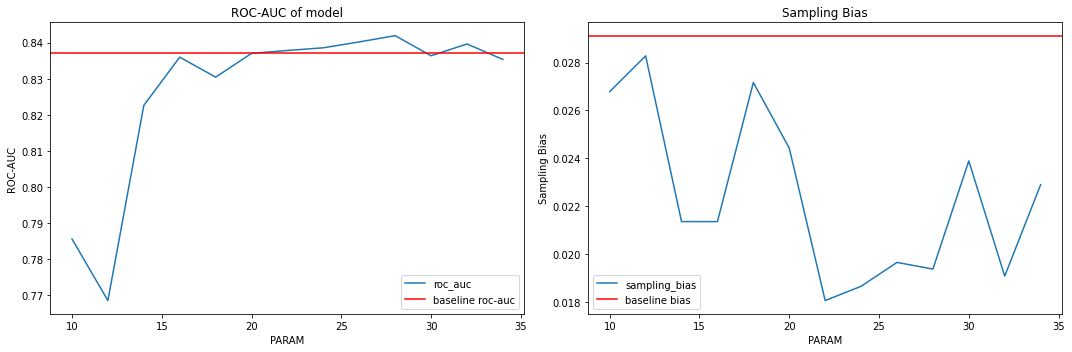

In [27]:
n_years = 20
model = lgbm.LGBMClassifier() # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)
datasetname = "gmsc.csv"

## ------------------------------------------------------------
## Get a Baseline Bias Measue without any reject inference
## ------------------------------------------------------------

sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

last_n_years = 5
baseline_bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
baseline_roc_auc = sum(metrics["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years
print(f'Baseline Sampling Bias: {round(baseline_bias, 5)}\nBaseline ROC-AUC: {round(baseline_roc_auc, 5)}')

## -----------------------------------------------------------------------
## Loop through Autoencoder training and testing for a parameter
## -----------------------------------------------------------------------

BATCH_SIZE = 2000
EPOCHS = 25
LR = 1e-3

sampling_bias = []
roc_auc = []
startvalue = 10
stopvalue = 35
step = 2
for PARAM in range(startvalue, stopvalue, step):
    # Train Autoencoder
    LOSSFUNCWEIGHTS = [0.1, 0.9, 0.0]  #[MMSE, KLDiv, MMD]

    dataset = aenc.CreditscoringDataset(datasetname)      # load and prepare Dataset to Tensor
    data_loader = aenc.DataLoader(                       # create Dataloader for batching
        dataset, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=True
    )

    shape = [dataset.x.shape[1], 45, PARAM, 45, dataset.x.shape[1]]  # define shape of Autoencoder PARAM = 25
    net = aenc.Autoencoder(shape)
    #print(net)
    net.to("cpu")

    train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR, LOSSFUNCWEIGHTS)

    # Simulate on encoded Data to measure sampling bias

    sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
    results_generator = sim.run()

    metrics2 = None
    for iteration in results_generator:
        #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
        metrics2 = iteration[3]


    sampling_bias.append(h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years))
    roc_auc.append(sum(metrics2["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)
    print(f'PARAM: {PARAM} | Sampling Bias: {round(sampling_bias[-1], 5)} // ROC-AUC: {round(roc_auc[-1], 5)}')

# Plot Results
x = range(startvalue, stopvalue, step)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(x, roc_auc, label = 'roc_auc')
axes[0].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
axes[0].legend()
axes[0].set_title("ROC-AUC of model")
axes[0].set_ylabel("ROC-AUC")
axes[0].set_xlabel("PARAM")

axes[1].plot(x, sampling_bias, label = 'sampling_bias')
axes[1].axhline(y = baseline_bias, color = 'r', label = 'baseline bias')
axes[1].legend()
axes[1].set_title("Sampling Bias")
axes[1].set_ylabel("Sampling Bias")
axes[1].set_xlabel("PARAM")
fig.tight_layout()


mit unseren geratenen 25 schon ganz gut ins schwarze getroffen :D

## Test basic Reject Inference Methods

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

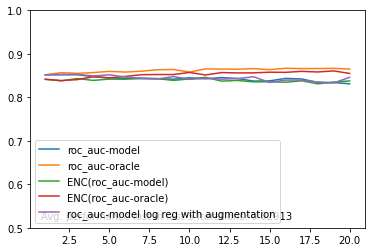

Sampling Bias: 0.02913


In [28]:
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=rinf.augmentation)
results_generator = sim.run()

metrics3 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics3 = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.plot(x, metrics3["model"]["holdout"]['roc_auc'], label = 'roc_auc-model log reg with augmentation')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 34)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 34)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 34)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 34)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 34)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 34)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 34)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 34)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 34)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 34)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 34)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 34)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

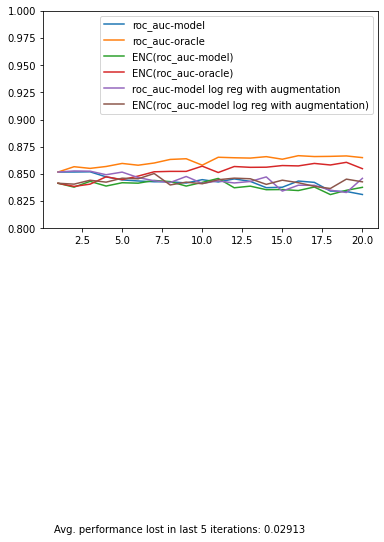

Sampling Bias: 0.02913


In [29]:
sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net, rej_inf=rinf.augmentation)
results_generator = sim.run()

metrics4 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics4 = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.plot(x, metrics3["model"]["holdout"]['roc_auc'], label = 'roc_auc-model log reg with augmentation')
plt.plot(x, metrics4["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model log reg with augmentation)')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.8, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

In [35]:
metrics4["model"]["holdout"]['roc_auc']

[0.8608789133107744,
 0.8602977490179873,
 0.8601653942184185,
 0.8599629019353018,
 0.859719752792211,
 0.8595187565407383,
 0.8591413165571278,
 0.8589952334671783,
 0.858963816802653,
 0.8587888691021593,
 0.8587779568713438,
 0.8586799227977271,
 0.8586854669149963,
 0.8586214015598858,
 0.8585059431177089,
 0.8583310834190766,
 0.8583793964409935,
 0.8582475696525932,
 0.8583145390691305,
 0.8582458096153648]